In [34]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [35]:
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader
from torchaudio.datasets import LIBRISPEECH
from torchaudio.transforms import MelSpectrogram, Resample
import os

In [36]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [37]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
12.1
1
NVIDIA GeForce GTX 1660


In [38]:
# Define a custom transform (Mel spectrogram transformation)
transform = nn.Sequential(MelSpectrogram(sample_rate=16000, n_mels=40))

### što je dropout, zašto

In [72]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, hidden_size=128, num_layers=2, output_size=40):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = None
        self.fc = None
        self.dropout = nn.Dropout(0.3) 


    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        #print("Shape after conv2:", x.shape)
        batch, channels, time, freq = x.shape
        x = x.permute(0, 2, 1, 3).contiguous().view(batch, time, channels * freq)
        # Dynamically create LSTM and FC if not already created
        if self.lstm is None or self.fc is None:
            self.lstm = nn.LSTM(input_size=channels * freq, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True).to(x.device)
            self.fc = nn.Linear(self.hidden_size, self.output_size).to(x.device)
            self.lstm.flatten_parameters()
            self.add_module('lstm', self.lstm)
            self.add_module('fc', self.fc)
        lstm_out, _ = self.lstm(x)
        x = self.dropout(self.fc(lstm_out))
        x = x.permute(1, 0, 2)  # [time, batch, classes]
        return x

In [63]:
# Define CTC Loss function
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

In [64]:
class LibriSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, subset="train-clean-100", transform=None, max_duration=10.0):
        self.root_dir = root_dir
        self.subset = subset
        self.transform = transform
        self.data = []

        max_transcript_words = 20 # broj rijeci


        subset_dir = os.path.join(self.root_dir, subset)
        for speaker in os.listdir(subset_dir):
            speaker_path = os.path.join(subset_dir, speaker)
            if os.path.isdir(speaker_path):
                for chapter in os.listdir(speaker_path):
                    chapter_path = os.path.join(speaker_path, chapter)
                    if os.path.isdir(chapter_path):
                        trans_file = os.path.join(chapter_path, f"{speaker}-{chapter}.trans.txt")
                        audio_files = [f for f in os.listdir(chapter_path) if f.endswith('.flac')]
                        # Read all transcriptions into a dict
                        trans_dict = {}
                        with open(trans_file, 'r') as f:
                            for line in f:
                                parts = line.strip().split(' ', 1)
                                if len(parts) == 2:
                                    trans_dict[parts[0]] = parts[1]
                        # Now filter audio files (OUTSIDE the with open block)
                        for audio_file in audio_files:
                            audio_path = os.path.join(chapter_path, audio_file)
                            waveform, sample_rate = torchaudio.load(audio_path)
                            duration = waveform.shape[1] / sample_rate
                            utt_id = audio_file.replace('.flac', '')
                            transcription = trans_dict.get(utt_id, "")
                            if duration <= max_duration and len(transcription.split()) <= max_transcript_words:
                                print(f"Duration: {duration:.2f}s, Transcript length: {len(transcription)}, Text: {transcription}")
                                self.data.append({
                                    'audio': audio_path,
                                    'transcription': transcription
                                })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        waveform, sample_rate = torchaudio.load(sample['audio'])  # [1, T]
        waveform = waveform.squeeze(0)  # shape: [T]
        if self.transform:
            spectrogram = self.transform(waveform)  # shape: [n_mels, time]
            spectrogram = spectrogram.unsqueeze(0)  # [1, n_mels, time] ← only 1 channel
            return spectrogram, sample['transcription']
        return waveform.unsqueeze(0), sample['transcription']

FIXED_TIME_STEPS = 256, povećao s 128, jer onda je bilo pre malo output character predictiona, a pošto sam povećao moguć input da proširim dataset
onda duže rečenice fizički nisu mogle biti reprezentirane


In [ ]:
import torch
import torch.nn.functional as F

FIXED_INPUT_LENGTH = 8000  # or another value that fits your dataset
FIXED_TIME_STEPS = 256  # Adjust this value based on your MelSpectrogram output and model

def pad_waveform(waveform, target_length=FIXED_INPUT_LENGTH):
    # waveform shape: [channels, time] or [1, time]
    waveform_length = waveform.size(1)
    if waveform_length < target_length:
        padding = target_length - waveform_length
        waveform = F.pad(waveform, (0, padding))
    elif waveform_length > target_length:
        waveform = waveform[:, :target_length]
    return waveform

# Example: simple character map (extend as needed)
char_map = {c: i+1 for i, c in enumerate("abcdefghijklmnopqrstuvwxyz '")}
char_map['<blank>'] = 0
def text_to_int_sequence(text):
    return [char_map.get(c, 0) for c in text.lower()]

def resize_spec(spec, target_width=FIXED_TIME_STEPS):
    current_width = spec.shape[-1]
    if current_width < target_width:
        return F.pad(spec, (0, target_width - current_width))
    else:
        return spec[..., :target_width]
def collate_fn(batch):
    spectrograms = [resize_spec(item[0]) for item in batch]
    transcripts = [item[1] for item in batch]

    spectrograms = torch.stack(spectrograms)  # shape: [B, 1, 40, FIXED_TIME_STEPS]

    # Targets
    targets = []
    target_lengths = []
    for t in transcripts:
        int_seq = text_to_int_sequence(t)
        targets.extend(int_seq)
        target_lengths.append(len(int_seq))

    targets = torch.tensor(targets, dtype=torch.long)
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return spectrograms, targets, target_lengths


## DONT FORGET TO RELOAD DATALOADER IF YOU FILTER FOR LENGTH ILI NEŠTO DRUGO

In [60]:
dataset = LibriSpeechDataset(
    root_dir=r"X:\AIx\PROJECTS\voiceToText\mojModel\data\LibriSpeech",
    subset="train-clean-100",
    transform=transform
)


Duration: 3.81s, Transcript length: 85, Text: IF HE'D RUN OUT OF TURNIP SEED HE WOULDN'T DRESS UP AND TAKE THE BUGGY TO GO FOR MORE
Duration: 3.02s, Transcript length: 61, Text: I HAD MADE UP MY MIND THAT IF YOU DIDN'T COME FOR ME TO NIGHT
Duration: 4.83s, Transcript length: 100, Text: IT'S WORSE THAN ANYTHING YOU COULD IMAGINE MISSUS SPENCER SAID IT WAS WICKED OF ME TO TALK LIKE THAT
Duration: 5.73s, Transcript length: 112, Text: AND ALTHOUGH HE FOUND IT RATHER DIFFICULT FOR HIS SLOWER INTELLIGENCE TO KEEP UP WITH HER BRISK MENTAL PROCESSES
Duration: 7.88s, Transcript length: 52, Text: CHAPTER NINETY NINE THE LAW WE HAVE SEEN HOW QUIETLY
Duration: 2.81s, Transcript length: 55, Text: WAS ASCENDING THE STAIRS LEADING TO DEBRAY'S APARTMENTS
Duration: 5.01s, Transcript length: 87, Text: DEBRAY WAS OCCUPIED IN REPELLING THE INSINUATIONS OF A FRIEND WHO TRIED TO PERSUADE HIM
Duration: 4.51s, Transcript length: 95, Text: AND THE CONVERSATION WHICH HAD BECOME INTERESTING DURING THE DISCUSSION

In [66]:
print(f"Total filtered samples: {len(dataset)}")

Total filtered samples: 3571


In [67]:
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [46]:
#model = CNN_LSTM_Model(hidden_size=128, output_size=40)
    # Run one batch through model to initialize LSTM/FC
#inputs, _, _ = next(iter(train_loader))
#_ = model(inputs.to(torch.float32))
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [69]:
model = CNN_LSTM_Model(hidden_size=128, output_size=40).to(device)
# Run one batch through model to initialize LSTM/FC
inputs, _, _ = next(iter(train_loader))
print("Shape before model:", inputs.shape)  # should be [B, 1, 40, T]
_ = model(inputs.to(torch.float32).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)



Shape before model: torch.Size([2, 1, 40, 128])


In [49]:
#!pip install tqdm

In [70]:
inv_char_map = {v: k for k, v in char_map.items()}

def decode_prediction(pred):
    # Collapse repeated characters and remove blanks (0)
    decoded = []
    prev = -1
    for p in pred:
        if p != prev and p != 0:
            decoded.append(inv_char_map.get(p, '?'))
        prev = p
    return ''.join(decoded)

def decode_target(target_seq):
    return ''.join(inv_char_map.get(t, '?') for t in target_seq if t != 0)

In [52]:
!pip install jiwer


  Obtaining dependency information for jiwer from https://files.pythonhosted.org/packages/69/c9/172c525330c739a068c01050759a6f855ce16212db10a0359e690a03ac48/jiwer-4.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for click>=8.1.8 from https://files.pythonhosted.org/packages/85/32/10bb5764d90a8eee674e9dc6f4db6a0ab47c8c4d0d83c27f7c39ac415a4d/click-8.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for rapidfuzz>=3.9.7 from https://files.pythonhosted.org/packages/a7/68/7248addf95b6ca51fc9d955161072285da3059dd1472b0de773cff910963/rapidfuzz-3.13.0-cp310-cp310-win_amd64.whl.metadata
   ---------------------------------------- 0.0/102.2 kB ? eta -:--:--
   ---------------------------------------- 102.2/102.2 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   --------------- ------------------------ 0.6/1.6 MB 13.5 MB/s eta 0:00:01
   -------------------------------------- - 1.5/1.6 MB 16.3 MB/s eta 0:00:01
   ------

treba fine tuneat, ako je target_length veći od output_time_steps ni dobro

napravit cu i ovo

self.pool = nn.MaxPool2d((2, 2))  # ⛔ reduces both time & freq
This halves time resolution.

➡️ Change it to:

self.pool = nn.MaxPool2d((2, 1))  # ✅ only reduces frequency, keeps time
This preserves more time steps → longer output.

🔧 Option C: Combine both (best)


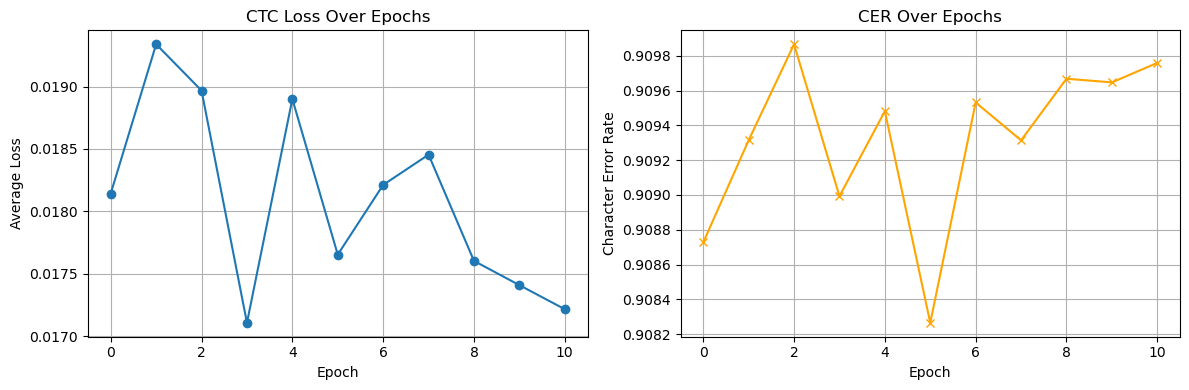

Epoch 11 Average Loss: 0.0172
Epoch 11 Average CER:  0.9098


Epoch 12:   0%|          | 7/1786 [00:00<00:27, 65.42it/s]

Output shape: torch.Size([20, 2, 40])
Target lengths: [80, 103]

Wanted:    and the bottle will come by first mail in a plain wrapper with full explanations
Predicted: abababcad
CER:       0.94
Epoch 12 Batch 1 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [62, 70]

Wanted:    waited two days and then descended the river with his prisoner
Predicted: abdbfbackacab
CER:       0.92
Epoch 12 Batch 2 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [25, 81]

Wanted:    for love i have heard say
Predicted: bacebacabacda
CER:       0.80
Epoch 12 Batch 3 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [116, 79]

Wanted:    advertisements setting forth the main facts were inserted in the principal newspapers of toronto hamilton and london
Predicted: fdafcfagaajfl
CER:       0.93
Epoch 12 Batch 4 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [32, 91]

Wanted:    one bitter day when they seek it
Predicted: hcbdacbcaaa


Epoch 12:   1%|          | 21/1786 [00:00<00:27, 65.11it/s]

Epoch 12 Batch 12 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [29, 26]

Wanted:    pink and blue he'll catch you
Predicted: bdebhafcbcf
CER:       0.83
Epoch 12 Batch 13 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [55, 89]

Wanted:    if anybody tells you that it's only just to put you off
Predicted: bcbcbabhj
CER:       0.95
Epoch 12 Batch 14 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [72, 35]

Wanted:    season with salt and pepper dip in egg and corn meal and fry in deep fat
Predicted: bgacbdbaabe
CER:       0.92
Epoch 12 Batch 15 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [99, 86]

Wanted:    but mabel staring out into the darkening heavens had seen the stars come out like jewels one by one
Predicted: abnbacejdca
CER:       0.93
Epoch 12 Batch 16 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [61, 54]

Wanted:    with a spade i turned up the black ground while she ran a

Epoch 12:   2%|▏         | 35/1786 [00:00<00:27, 62.79it/s]

Output shape: torch.Size([20, 2, 40])
Target lengths: [29, 104]

Wanted:    all right sit down my friends
Predicted: aghfffbdef
CER:       0.83
Epoch 12 Batch 25 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [99, 65]

Wanted:    for a time he ate with great deliberation and revolved an interesting thought in his mind years ago
Predicted: daccecadaeb
CER:       0.94
Epoch 12 Batch 26 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [87, 64]

Wanted:    i happened to dodge a ball fired from the other side and it went through the glass what
Predicted: cbdbebafabddab
CER:       0.91
Epoch 12 Batch 27 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [75, 107]

Wanted:    un gout bizarre vraiment but i love very much to be near to the dead people
Predicted: aagfdkbgcfahabg
CER:       0.91
Epoch 12 Batch 28 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [94, 39]

Wanted:    it was difficult to believe that it was the

Epoch 12:   2%|▏         | 42/1786 [00:00<00:27, 64.25it/s]

Epoch 12 Batch 36 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [38, 84]

Wanted:    the fortifications are quite destroyed
Predicted: bfafaaabe
CER:       0.87
Epoch 12 Batch 37 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [57, 61]

Wanted:    skeletons they were and no human beings at all her father
Predicted: acehbcafbaea
CER:       0.88
Epoch 12 Batch 38 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [54, 87]

Wanted:    so fine and soft and glossy such a beautiful color too
Predicted: bdbabeblbabc
CER:       0.89
Epoch 12 Batch 39 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [27, 39]

Wanted:    and i've hurt you like this
Predicted: aacadccfbabc
CER:       0.96
Epoch 12 Batch 40 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [112, 123]

Wanted:    for examples of the second sort of lineage that began with greatness and maintains it still without adding to it
Predicted: cbgfacb

Epoch 12:   3%|▎         | 56/1786 [00:00<00:26, 65.54it/s]

Output shape: torch.Size([20, 2, 40])
Target lengths: [90, 76]

Wanted:    she was a skin deep papist her catholicism did not exceed the amount necessary for fashion
Predicted: ajadbfagaagbcab
CER:       0.91
Epoch 12 Batch 49 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [55, 41]

Wanted:    with a brandy bottle under her apron stealing up stairs
Predicted: cdbbacdaeagda
CER:       0.85
Epoch 12 Batch 50 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [111, 54]

Wanted:    vicar of abedare asserting that the fall had occurred chiefly upon the property of mister nixon of mountain ash
Predicted: cidaafadae
CER:       0.93
Epoch 12 Batch 51 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [77, 51]

Wanted:    why should a head be required what kind of man would be likely to want a head
Predicted: fnaacbacagabb
CER:       0.92
Epoch 12 Batch 52 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [84, 67]

Wanted:    

Epoch 12:   4%|▍         | 70/1786 [00:01<00:26, 63.75it/s]

Epoch 12 Batch 61 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [98, 27]

Wanted:    that restored and inspirited me the fare was indeed coarse such as the peasants of the country ate
Predicted: aabaaefbada
CER:       0.93
Epoch 12 Batch 62 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [54, 45]

Wanted:    they merit richly that piece of attention on your part
Predicted: edadiaeabcbc
CER:       0.91
Epoch 12 Batch 63 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [45, 61]

Wanted:    test it yourself free a real hair restorative
Predicted: babdbadcddba
CER:       0.93
Epoch 12 Batch 64 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [87, 126]

Wanted:    it was teeter the spotted sandpiper an old friend of peter's peter greeted him joyously
Predicted: iadcabaldaecbcb
CER:       0.91
Epoch 12 Batch 65 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [93, 128]

Wanted:    if the cruel power

Epoch 12:   5%|▍         | 84/1786 [00:01<00:26, 64.77it/s]

Epoch 12 Batch 73 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [110, 84]

Wanted:    the captain's bragging propensities were exercised in cracking up the speed of his boat which by his reckoning
Predicted: gdbavcdgaaka
CER:       0.94
Epoch 12 Batch 74 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [104, 73]

Wanted:    no doubt they told each other that the princess hyacinth bless her pretty face had found her man at last
Predicted: acbdabcbibcba
CER:       0.92
Epoch 12 Batch 75 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [48, 66]

Wanted:    who was full of wonder when she saw him and said
Predicted: abdcdaagagbgabab
CER:       0.90
Epoch 12 Batch 76 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [104, 73]

Wanted:    besides on this well chosen plateau the cable never lies at depths that could cause a break the nautilus
Predicted: eecajeabca
CER:       0.91
Epoch 12 Batch 77 Loss: 0.0000
Output sh

Epoch 12:   5%|▌         | 91/1786 [00:01<00:26, 64.60it/s]

Epoch 12 Batch 85 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [109, 98]

Wanted:    that unless you hear about them separately and one by one you can't for a moment understand what they're like
Predicted: jeaejabgdabha
CER:       0.92
Epoch 12 Batch 86 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [105, 53]

Wanted:    mister hill of texas is reputed to be a millionaire howard gansworth a graduate of carlisle and princeton
Predicted: acadafbcbadhbca
CER:       0.91
Epoch 12 Batch 87 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [59, 94]

Wanted:    that such primitive methods are still all that they use all
Predicted: bbafafabdcadjd
CER:       0.93
Epoch 12 Batch 88 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [82, 60]

Wanted:    language itself is proof of it many algonkin words for east morning dawn day light
Predicted: cbaqabafuabcah
CER:       0.91
Epoch 12 Batch 89 Loss: 0.0000
Output shape: to

Epoch 12:   6%|▌         | 105/1786 [00:01<00:26, 63.09it/s]

Epoch 12 Batch 97 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [81, 37]

Wanted:    in this enterprise i endeavoured to pick up as many flowers as i could by the way
Predicted: dabbcbacbac
CER:       0.91
Epoch 12 Batch 98 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [94, 43]

Wanted:    and making a kind of circular sweep invited you to step this way and so led you beyond his ken
Predicted: afidbgfcacb
CER:       0.93
Epoch 12 Batch 99 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [51, 98]

Wanted:    that would do if it was the toothache my master had
Predicted: cbceafbacbaada
CER:       0.90
Epoch 12 Batch 100 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [101, 73]

Wanted:    and did you sign it asked jessica i certainly did not responded mabel it was she stopped then flushed
Predicted: cebfagdccdbdb
CER:       0.93
Epoch 12 Batch 101 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengt

Epoch 12:   7%|▋         | 119/1786 [00:01<00:25, 64.92it/s]

Output shape: torch.Size([20, 2, 40])
Target lengths: [114, 57]

Wanted:    captain nemo had no liking for the neighborhood of brazil's populous shores because he shot by with dizzying speed
Predicted: gfdafdaabcao
CER:       0.92
Epoch 12 Batch 109 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [53, 29]

Wanted:    when the sails flap idly against the unstrained masts
Predicted: bibbagacac
CER:       0.91
Epoch 12 Batch 110 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [77, 55]

Wanted:    pointed out editorially in its issue of april twenty first nineteen seventeen
Predicted: abghpbabgabdba
CER:       0.97
Epoch 12 Batch 111 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [108, 102]

Wanted:    the purple pride which on thy soft cheek for complexion dwells in my love's veins thou hast too grossly dy'd
Predicted: ecabchtacdcbd
CER:       0.93
Epoch 12 Batch 112 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths

Epoch 12:   7%|▋         | 126/1786 [00:02<00:25, 65.25it/s]

Epoch 12 Batch 121 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [47, 75]

Wanted:    all the rest is readily explained by psychology
Predicted: dcdababbadaca
CER:       0.91
Epoch 12 Batch 122 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [61, 72]

Wanted:    and christianity but he was not satisfied with either of them
Predicted: bacfejabgadb
CER:       0.92
Epoch 12 Batch 123 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [124, 93]

Wanted:    receives no impressions either human or pleasant or painful with the exception of earthquakes and catastrophes this devotion
Predicted: eacbdahchedlb
CER:       0.93
Epoch 12 Batch 124 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [29, 72]

Wanted:    you might wonder why i didn't
Predicted: fbcjaafead
CER:       0.93
Epoch 12 Batch 125 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [86, 103]

Wanted:    when they were unhappy i felt depresse

Epoch 12:   8%|▊         | 140/1786 [00:02<00:25, 63.45it/s]

Epoch 12 Batch 133 Loss: 0.8518
Output shape: torch.Size([20, 2, 40])
Target lengths: [36, 53]

Wanted:    most economical and effective remedy
Predicted: adadhcbabab
CER:       0.89
Epoch 12 Batch 134 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [74, 94]

Wanted:    well well said emily impatiently and anxious to enquire on another subject
Predicted: acbcacaecabg
CER:       0.92
Epoch 12 Batch 135 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [88, 109]

Wanted:    fortified by these assurances the dark figure left the brow of the natural rocky terrace
Predicted: agaaeadacpc
CER:       0.91
Epoch 12 Batch 136 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [26, 50]

Wanted:    they are in short peasants
Predicted: fdaeocgbecai
CER:       0.81
Epoch 12 Batch 137 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [98, 37]

Wanted:    we'd be pack horses if we tried to carry any more truck along of course frank 

Epoch 12:   9%|▊         | 154/1786 [00:02<00:25, 64.80it/s]

Epoch 12 Batch 145 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [44, 54]

Wanted:    leaving the place beneath clear of its fumes
Predicted: cabadapdcabca
CER:       0.86
Epoch 12 Batch 146 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [72, 93]

Wanted:    how did it happen to be election time why did the inns chance to be full
Predicted: fdcaecadbb
CER:       0.92
Epoch 12 Batch 147 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [41, 83]

Wanted:    locks will present very little difficulty
Predicted: afdhdcbafabade
CER:       0.98
Epoch 12 Batch 148 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [77, 41]

Wanted:    and miss mabel vernon of delaware miss lavinia dock of pennsylvania miss maud
Predicted: ahafbaf
CER:       0.94
Epoch 12 Batch 149 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [32, 99]

Wanted:    where is peep asked missus cluck
Predicted: eababdaba
CER:       0.91
E

Epoch 12:   9%|▉         | 168/1786 [00:02<00:25, 63.76it/s]

Epoch 12 Batch 157 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [89, 44]

Wanted:    and away the bearers went for three days and three nights until they came to a dense wood
Predicted: chbedbebcefhaec
CER:       0.89
Epoch 12 Batch 158 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [122, 42]

Wanted:    for the mysterious murderer whose identity lecoq was trying to establish had furnished three victims for their delectation
Predicted: aacadadabfcfb
CER:       0.94
Epoch 12 Batch 159 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [23, 69]

Wanted:    no john no she answered
Predicted: eadbadcdca
CER:       0.96
Epoch 12 Batch 160 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [19, 114]

Wanted:    barbaik was furious
Predicted: egbambgafbdaga
CER:       0.79
Epoch 12 Batch 161 Loss: 1.1775
Output shape: torch.Size([20, 2, 40])
Target lengths: [95, 56]

Wanted:    then came hatred and wicked thoughts that 

Epoch 12:  10%|▉         | 175/1786 [00:02<00:25, 64.25it/s]

Epoch 12 Batch 169 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [103, 91]

Wanted:    said my uncle toby musing whilst a man is free cried the corporal giving a flourish with his stick thus
Predicted: badbacabefha
CER:       0.92
Epoch 12 Batch 170 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [37, 29]

Wanted:    has gone to the billiard room i think
Predicted: bcsjgedcbfd
CER:       0.86
Epoch 12 Batch 171 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [48, 54]

Wanted:    he himself slept peacefully and snored aloud yet
Predicted: baafccbaca
CER:       0.92
Epoch 12 Batch 172 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [83, 95]

Wanted:    will afford the means of readily determining what should be thought of all the rest
Predicted: cebcbaijdaca
CER:       0.93
Epoch 12 Batch 173 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [65, 79]

Wanted:    he has never spoken of it to me 

Epoch 12:  11%|█         | 189/1786 [00:02<00:24, 64.95it/s]

Epoch 12 Batch 181 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [85, 96]

Wanted:    then the princess sent for her father and told him that she wished to marry ameer ali
Predicted: bcbacbicbac
CER:       0.95
Epoch 12 Batch 182 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [52, 70]

Wanted:    ain't that something done after you've done all that
Predicted: cbfdbacabdaa
CER:       0.90
Epoch 12 Batch 183 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [79, 86]

Wanted:    when they had retired to rest if there was any moon or the night was star light
Predicted: badbcahbcab
CER:       0.94
Epoch 12 Batch 184 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [52, 48]

Wanted:    and besides him there is no other judith chapter six
Predicted: cdbcaeaidag
CER:       0.88
Epoch 12 Batch 185 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [43, 83]

Wanted:    such a figure was appropriate to the

Epoch 12:  11%|█▏        | 203/1786 [00:03<00:25, 63.09it/s]

Output shape: torch.Size([20, 2, 40])
Target lengths: [99, 31]

Wanted:    then he remarked that the eruption of vesuvius was waning and the trouble nearly over for this time
Predicted: dbajbdaaa
CER:       0.95
Epoch 12 Batch 194 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [97, 66]

Wanted:    now it was like the terrible gleam of visible omnipotence now like a soft ray of golden childhood
Predicted: baacldaacd
CER:       0.92
Epoch 12 Batch 195 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [46, 46]

Wanted:    they are simultaneously affections of the body
Predicted: acdceadabaa
CER:       0.91
Epoch 12 Batch 196 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [116, 72]

Wanted:    some weeks before this period i had procured a sledge and dogs and thus traversed the snows with inconceivable speed
Predicted: bahabamiaabf
CER:       0.94
Epoch 12 Batch 197 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [

Epoch 12:  12%|█▏        | 210/1786 [00:03<00:24, 63.25it/s]

Epoch 12 Batch 205 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [101, 34]

Wanted:    except the groin said my uncle toby an please your honour replied the corporal the knee in my opinion
Predicted: cagecfeadgafac
CER:       0.93
Epoch 12 Batch 206 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [96, 82]

Wanted:    it is only the gay and innocent and heartless who can fly what is gay and innocent and heartless
Predicted: ambdccaaedce
CER:       0.91
Epoch 12 Batch 207 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [97, 88]

Wanted:    but still the cake was eaten and there was no rest for his benevolent nerves till it was all gone
Predicted: cdbdcaedbcab
CER:       0.94
Epoch 12 Batch 208 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [51, 104]

Wanted:    and far beyond it is the grand monadnock in jaffrey
Predicted: jabaaegbadbd
CER:       0.86
Epoch 12 Batch 209 Loss: 0.0000
Output shape: torch.Size([2

Epoch 12:  13%|█▎        | 224/1786 [00:03<00:24, 64.52it/s]

Epoch 12 Batch 217 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [77, 91]

Wanted:    in case he should publish a second edition of his book to omit the dedication
Predicted: abcacbafbc
CER:       0.91
Epoch 12 Batch 218 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [107, 75]

Wanted:    the only sound which disturbed the stillness was the sound of the rain beating in gusts against the windows
Predicted: abdaadbabfeca
CER:       0.93
Epoch 12 Batch 219 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [33, 56]

Wanted:    much could be done in three years
Predicted: dahcafacab
CER:       0.91
Epoch 12 Batch 220 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [42, 50]

Wanted:    ah like the charming journey the other day
Predicted: abgcacabcagd
CER:       0.88
Epoch 12 Batch 221 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [62, 59]

Wanted:    i'm looking for something i've lost myself i

Epoch 12:  13%|█▎        | 238/1786 [00:03<00:24, 64.49it/s]

Epoch 12 Batch 229 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [41, 69]

Wanted:    and no signature i believe sir said jerry
Predicted: bbamdfabbbcb
CER:       0.95
Epoch 12 Batch 230 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [104, 93]

Wanted:    a geometric thought of the great cause of god if you will made material it was airless waterless sunless
Predicted: dadfeabdhafb
CER:       0.94
Epoch 12 Batch 231 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [65, 41]

Wanted:    await me here he said to the five men under his immediate command
Predicted: acecbababkaaaaf
CER:       0.92
Epoch 12 Batch 232 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [101, 47]

Wanted:    destroyed a british squadron off leghorn march twenty third in both countries there was a peace party
Predicted: adhadhfjecbdabc
CER:       0.90
Epoch 12 Batch 233 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [80

Epoch 12:  14%|█▍        | 252/1786 [00:03<00:23, 64.71it/s]

Epoch 12 Batch 241 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [71, 76]

Wanted:    when he returned he told her that he would have to stay overnight there
Predicted: abedeadiag
CER:       0.90
Epoch 12 Batch 242 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [75, 39]

Wanted:    at that moment jerry came hurrying down the deck he was visibly excited but
Predicted: aababfba
CER:       0.93
Epoch 12 Batch 243 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [72, 36]

Wanted:    he put an arrow through it and it turned a somersault and fell over dead
Predicted: aeacabgcnacbc
CER:       0.92
Epoch 12 Batch 244 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [96, 53]

Wanted:    with all provisions sufficient for the armies in abundance and herds of oxen and flocks of sheep
Predicted: acdieaedafceba
CER:       0.89
Epoch 12 Batch 245 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [86, 51]

W

Epoch 12:  15%|█▍        | 259/1786 [00:04<00:23, 64.21it/s]

Epoch 12 Batch 253 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [77, 19]

Wanted:    and that they would just stand pat now and wait for him to make the next move
Predicted: bfbcjacekecabec
CER:       0.94
Epoch 12 Batch 254 Loss: 1.0228
Output shape: torch.Size([20, 2, 40])
Target lengths: [75, 97]

Wanted:    an accident happened to jean valjean he crushed the thumb of his right hand
Predicted: abkbabcbgcbf
CER:       0.93
Epoch 12 Batch 255 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [93, 110]

Wanted:    from this point the glacier as far as our view extended to the south looked better and better
Predicted: acdhaiacacbedbd
CER:       0.90
Epoch 12 Batch 256 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [87, 40]

Wanted:    they are nearer than ever life and love never change death is an unreality thought made
Predicted: ecbeabadkad
CER:       0.92
Epoch 12 Batch 257 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])


Epoch 12:  15%|█▌        | 273/1786 [00:04<00:23, 63.64it/s]

Epoch 12 Batch 265 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [73, 80]

Wanted:    above all was the sense of hearing acute i heard all things in the heaven
Predicted: dbibcicaefb
CER:       0.92
Epoch 12 Batch 266 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [62, 107]

Wanted:    before she started to keep her appointment with the solicitors
Predicted: bgacahbedcabcdcda
CER:       0.90
Epoch 12 Batch 267 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [103, 66]

Wanted:    it was nearly three hundred miles by the windings of the stream before one reached that algonquin tribe
Predicted: babababafdga
CER:       0.92
Epoch 12 Batch 268 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [46, 35]

Wanted:    which slightly press'd against the calf of his
Predicted: mabbcdbaeca
CER:       0.89
Epoch 12 Batch 269 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [68, 54]

Wanted:    right he tho

Epoch 12:  16%|█▌        | 287/1786 [00:04<00:23, 63.53it/s]

Epoch 12 Batch 277 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [48, 127]

Wanted:    worshiped idols very few of them were christians
Predicted: cdbaabcfbdbar
CER:       0.94
Epoch 12 Batch 278 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [52, 59]

Wanted:    in various ways it was the prevalent opinion however
Predicted: jeadcbdfdf
CER:       0.96
Epoch 12 Batch 279 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [90, 28]

Wanted:    for a moment the absurdity of the thing drove every other thought out of montgomery's head
Predicted: cceacabda
CER:       0.94
Epoch 12 Batch 280 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [46, 111]

Wanted:    so the three of us with zverkov for the fourth
Predicted: aeadegcbeabfe
CER:       0.89
Epoch 12 Batch 281 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [58, 28]

Wanted:    and yet you are right it really is vulgar and contemptible
Predict

Epoch 12 Batch 289 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [81, 31]

Wanted:    these were the kind of men with whom he would converse longest and most seriously
Predicted: dcbcbeaeabbadb
CER:       0.93
Epoch 12 Batch 290 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [91, 115]

Wanted:    but a million dollars in the hands of a person who truly wants to do with it as jesus would
Predicted: aabaqacbajbeba
CER:       0.93
Epoch 12 Batch 291 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [94, 105]

Wanted:    captain anderson his officers and the engineers put their heads together then posted a warning
Predicted: cbcbahckbabeafc
CER:       0.93
Epoch 12 Batch 292 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [108, 42]

Wanted:    in those times all towns of any great size were surrounded by strong walls there was war constantly going on
Predicted: bebeadcbjabfea
CER:       0.93
Epoch 12 Batch 293 Los

Epoch 12:  17%|█▋        | 307/1786 [00:04<00:25, 58.20it/s]

Epoch 12 Batch 299 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [54, 48]

Wanted:    this story however i regard with a great deal of doubt
Predicted: aabeaeabhjh
CER:       0.89
Epoch 12 Batch 300 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [44, 78]

Wanted:    and on perceiving whom she said to the girls
Predicted: cebfehedabcbic
CER:       0.86
Epoch 12 Batch 301 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [71, 98]

Wanted:    from beneath the snowy ground early in the morning before she had risen
Predicted: cafbaiaibg
CER:       0.93
Epoch 12 Batch 302 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [93, 38]

Wanted:    had not the jews prevented it if thou let this man go thou art not caesar's friend they cried
Predicted: bagfaffaeada
CER:       0.92
Epoch 12 Batch 303 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [52, 35]

Wanted:    is well known as an evangelistic preache

Epoch 12:  18%|█▊        | 319/1786 [00:05<00:25, 57.23it/s]

Epoch 12 Batch 310 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [48, 100]

Wanted:    my manner as i thus addressed him was impressive
Predicted: cdccfcdababdac
CER:       0.92
Epoch 12 Batch 311 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [71, 109]

Wanted:    will you not tell me something about it said the curate yet more gently
Predicted: bfcagbcdbaaa
CER:       0.94
Epoch 12 Batch 312 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [88, 83]

Wanted:    that an involuntary terror sweeps over me and my lungs still seem short of air meanwhile
Predicted: dcebdgeaca
CER:       0.93
Epoch 12 Batch 313 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [59, 51]

Wanted:    you re disappointed are n't you i confess i am disappointed
Predicted: abadacbacablacb
CER:       0.90
Epoch 12 Batch 314 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [48, 59]

Wanted:    and then asked lucy starting u

Epoch 12:  18%|█▊        | 325/1786 [00:05<00:26, 56.13it/s]

Epoch 12 Batch 320 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [33, 39]

Wanted:    then he went directly to her room
Predicted: raebababcaabia
CER:       0.94
Epoch 12 Batch 321 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [78, 72]

Wanted:    is an observation so directly offensive as to allow me but one line of conduct
Predicted: dadfbbcabcbab
CER:       0.92
Epoch 12 Batch 322 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [34, 94]

Wanted:    in whose service he had a relative
Predicted: bdachabdbeaga
CER:       0.85
Epoch 12 Batch 323 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [88, 95]

Wanted:    he sees current history from the absolutely opposite point of view say to the lyric poet
Predicted: adababdadcabcedc
CER:       0.94
Epoch 12 Batch 324 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [70, 46]

Wanted:    we'n best keep this matter to ourselves till thou comes int 

Epoch 12:  19%|█▉        | 339/1786 [00:05<00:24, 59.60it/s]

Epoch 12 Batch 331 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [124, 43]

Wanted:    and was altogether a very acceptable individual of our great american upper class the first grade below the luxuriously rich
Predicted: ifbfgddchadbab
CER:       0.94
Epoch 12 Batch 332 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [52, 89]

Wanted:    from the chest of drawers two candles the only light
Predicted: fdcabcacaebb
CER:       0.88
Epoch 12 Batch 333 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [45, 32]

Wanted:    it presents no appearance of that prognathism
Predicted: dabfcaabgba
CER:       0.89
Epoch 12 Batch 334 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [31, 80]

Wanted:    he loved to have the cloth laid
Predicted: abacedbdadcha
CER:       0.81
Epoch 12 Batch 335 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [92, 57]

Wanted:    before i could utter a word i was a prisoner b

Epoch 12:  19%|█▉        | 346/1786 [00:05<00:23, 61.46it/s]

Epoch 12 Batch 343 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [52, 42]

Wanted:    but when he came to look there was no key hole to it
Predicted: adeaacbdeac
CER:       0.92
Epoch 12 Batch 344 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [61, 68]

Wanted:    there was a round table that the woman used to lay for supper
Predicted: acadbdna
CER:       0.90
Epoch 12 Batch 345 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [59, 70]

Wanted:    and how great a development could they attain to thereafter
Predicted: gafacacjicbaeaib
CER:       0.86
Epoch 12 Batch 346 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [89, 96]

Wanted:    john is not here now she gasped is michael asleep he asked with a careless glance at jane
Predicted: abadabahba
CER:       0.93
Epoch 12 Batch 347 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [76, 65]

Wanted:    and someways the whole drove always showed 

Epoch 12:  20%|██        | 359/1786 [00:05<00:26, 54.63it/s]

Output shape: torch.Size([20, 2, 40])
Target lengths: [75, 39]

Wanted:    for in a society such as ours satire inflicts a painful and incurable wound
Predicted: ceabadbae
CER:       0.91
Epoch 12 Batch 353 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [37, 25]

Wanted:    somewhat resentful in her inmost soul
Predicted: bhbcaeac
CER:       0.95
Epoch 12 Batch 354 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [91, 75]

Wanted:    has led to mate himself below his rank then since i am introducing no new usage or practice
Predicted: bhbagcabc
CER:       0.93
Epoch 12 Batch 355 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [61, 66]

Wanted:    and monte cristo placed the bonds in his pocket with one hand
Predicted: dcaeafangbfca
CER:       0.89
Epoch 12 Batch 356 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [38, 50]

Wanted:    it don't sound a bit like other clocks
Predicted: edcbaciacfbba
CER:       0.8

Epoch 12:  21%|██        | 374/1786 [00:05<00:23, 60.73it/s]

Epoch 12 Batch 363 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [99, 53]

Wanted:    presented to him for the purpose of obtaining tickets of admission to the court on the day of trial
Predicted: cacbdecagdabdg
CER:       0.93
Epoch 12 Batch 364 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [41, 27]

Wanted:    back to the wall still his hands twitched
Predicted: bicedadbf
CER:       0.88
Epoch 12 Batch 365 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [69, 63]

Wanted:    it was of no great advantage to him for he was unable to follow it up
Predicted: dacbihbcdfagdc
CER:       0.91
Epoch 12 Batch 366 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [91, 120]

Wanted:    i admire her intellect but her political and social opinions i must always view with regret
Predicted: babada
CER:       0.95
Epoch 12 Batch 367 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [104, 99]

Wanted:    roma

Epoch 12:  21%|██▏       | 381/1786 [00:06<00:22, 63.05it/s]

Output shape: torch.Size([20, 2, 40])
Target lengths: [38, 60]

Wanted:    we had breakfast in the tavern kitchen
Predicted: eadabbbcad
CER:       0.87
Epoch 12 Batch 376 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [64, 122]

Wanted:    who wore their usual clothes and had not assumed the coarse garb
Predicted: djebbcaebdae
CER:       0.91
Epoch 12 Batch 377 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [42, 85]

Wanted:    who is there i can find for her to talk to
Predicted: debcgdcbaafbdae
CER:       0.88
Epoch 12 Batch 378 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [39, 75]

Wanted:    he was very busy with facts and figures
Predicted: dabjeadaabab
CER:       0.90
Epoch 12 Batch 379 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [63, 53]

Wanted:    whilst this was doing how could she forget to make him sensible
Predicted: acbabegabdfagb
CER:       0.90
Epoch 12 Batch 380 Loss: 0.0000
Output sha

Epoch 12:  22%|██▏       | 396/1786 [00:06<00:21, 64.08it/s]

Epoch 12 Batch 389 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [25, 75]

Wanted:    strangely mean and tawdry
Predicted: aedpocbacaia
CER:       0.80
Epoch 12 Batch 390 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [44, 107]

Wanted:    oh no it isn't so bad as that he was assured
Predicted: abcdabdcardgb
CER:       0.91
Epoch 12 Batch 391 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [31, 70]

Wanted:    pay him will you jenkins thanks
Predicted: caabhaccfc
CER:       0.94
Epoch 12 Batch 392 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [63, 90]

Wanted:    the juniors forever hurrah fans hurrah our team is a winner our
Predicted: hbbfcbebaaebg
CER:       0.90
Epoch 12 Batch 393 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [84, 45]

Wanted:    who suffer as i do from nervous complaints can have no great inclination for talking
Predicted: abegdaaaeadb
CER:       0.92
Epoch 12 Bat

Epoch 12:  23%|██▎       | 412/1786 [00:06<00:20, 67.76it/s]

Epoch 12 Batch 401 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [56, 49]

Wanted:    and the neighbors would say to each other in a low voice
Predicted: edamdagdfbabe
CER:       0.89
Epoch 12 Batch 402 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [43, 80]

Wanted:    venous artery open anew and allow a passage
Predicted: cebdcadabdcdab
CER:       0.88
Epoch 12 Batch 403 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [64, 50]

Wanted:    enabling them to carry a greater amount of freight within a year
Predicted: eafadldeabbfa
CER:       0.89
Epoch 12 Batch 404 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [71, 91]

Wanted:    i was entirely without friends nay even so much as without acquaintance
Predicted: bcchadaafe
CER:       0.92
Epoch 12 Batch 405 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [41, 52]

Wanted:    to the church of saint paul at that epoch
Predicted: acdbdecebejb

Epoch 12:  23%|██▎       | 419/1786 [00:06<00:20, 67.81it/s]

Epoch 12 Batch 414 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [69, 61]

Wanted:    but they walked in the middle of the great street neither on one side
Predicted: daadaedeb
CER:       0.93
Epoch 12 Batch 415 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [25, 71]

Wanted:    he might go back to araby
Predicted: dgaebabefbeda
CER:       0.84
Epoch 12 Batch 416 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [47, 42]

Wanted:    yes even morality the charming morality of love
Predicted: bfabcbaceaiihbc
CER:       0.89
Epoch 12 Batch 417 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [45, 106]

Wanted:    in the course of the day i received this note
Predicted: acadacaedbegc
CER:       0.87
Epoch 12 Batch 418 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [46, 94]

Wanted:    it is not a mere skeleton it is an entire body
Predicted: dahbagecabed
CER:       0.89
Epoch 12 Batch 419 Loss: 

Epoch 12:  24%|██▍       | 433/1786 [00:06<00:20, 66.52it/s]

Epoch 12 Batch 426 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [79, 71]

Wanted:    and keep a guard upon the money as for you jim he said it went against my heart
Predicted: abgachaacb
CER:       0.92
Epoch 12 Batch 427 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [49, 105]

Wanted:    he was so enraged at this that he again began war
Predicted: edabcagaibce
CER:       0.84
Epoch 12 Batch 428 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [29, 45]

Wanted:    what is it he cried shrinking
Predicted: cababcabdmha
CER:       0.86
Epoch 12 Batch 429 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [55, 121]

Wanted:    and once in a while only one but that isn't really safe
Predicted: addbdabbac
CER:       0.91
Epoch 12 Batch 430 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [68, 47]

Wanted:    then please keep it for me until to morrow papa will you yes he said
Predicted: afbaacabagb

Epoch 12:  25%|██▌       | 449/1786 [00:07<00:19, 68.48it/s]

Epoch 12 Batch 439 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [104, 75]

Wanted:    which is not exactly a child's foot with two pairs of reindeer skin stockings on and ten pairs were made
Predicted: baedbacacfaa
CER:       0.93
Epoch 12 Batch 440 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [97, 80]

Wanted:    and when she acted portia in the trial scene of the merchant of venice at the high school concert
Predicted: cgaagecida
CER:       0.93
Epoch 12 Batch 441 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [61, 120]

Wanted:    trying to imitate peter's crow no it wasn't jane said gravely
Predicted: amaaabfbaa
CER:       0.90
Epoch 12 Batch 442 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [82, 40]

Wanted:    and they caused the little children to lie prostrate before the temple of the lord
Predicted: aabafeacjcfa
CER:       0.93
Epoch 12 Batch 443 Loss: 0.0000
Output shape: torch.Size([20, 2, 4

Epoch 12:  26%|██▌       | 463/1786 [00:07<00:19, 67.81it/s]

Epoch 12 Batch 453 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [69, 93]

Wanted:    what decision have you been pleased to come to said he rostov stopped
Predicted: abcdabagmbanaca
CER:       0.88
Epoch 12 Batch 454 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [41, 88]

Wanted:    my goodness why didn't you say so i cried
Predicted: cbdjdababkba
CER:       0.93
Epoch 12 Batch 455 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [90, 46]

Wanted:    when the three riders who had left paris about six in the evening arrived at fontainebleau
Predicted: labjabcbach
CER:       0.94
Epoch 12 Batch 456 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [82, 45]

Wanted:    then extending his hand the old man said i thank you my son and now leave me alone
Predicted: cachdalkcecj
CER:       0.93
Epoch 12 Batch 457 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [51, 95]

Wanted:    is the middle let

Epoch 12:  26%|██▋       | 471/1786 [00:07<00:19, 68.55it/s]

Epoch 12 Batch 465 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [32, 65]

Wanted:    on all but the people themselves
Predicted: adacbadfcjcbg
CER:       0.94
Epoch 12 Batch 466 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [61, 43]

Wanted:    it's worth trying i said resolutely so let's try it professor
Predicted: ebaacodabbf
CER:       0.95
Epoch 12 Batch 467 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [92, 79]

Wanted:    by throwing his arm upward toward heaven and then letting it fall impressively on his breast
Predicted: aceiedjeagcbcfd
CER:       0.92
Epoch 12 Batch 468 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [27, 55]

Wanted:    then said the first soldier
Predicted: cgfbacaefcddhb
CER:       0.85
Epoch 12 Batch 469 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [101, 15]

Wanted:    who was sobbing and wiping her eyes with the corner of her apron enna took my block

Epoch 12:  27%|██▋       | 486/1786 [00:07<00:18, 69.41it/s]

Epoch 12 Batch 478 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [74, 106]

Wanted:    within a few minutes their running footsteps had died away in the distance
Predicted: fbdfaebabdfdbag
CER:       0.91
Epoch 12 Batch 479 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [109, 107]

Wanted:    from time to time at lyra's bidding the young fellow explained to annie some curious feature of the processes
Predicted: aabdbacjdgjc
CER:       0.94
Epoch 12 Batch 480 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [39, 64]

Wanted:    that nasmyth was no fool replied michel
Predicted: bacbeaabcbdb
CER:       0.90
Epoch 12 Batch 481 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [82, 92]

Wanted:    and i have often boasted that i obtained them all looking back over half a century
Predicted: dcaccdhga
CER:       0.93
Epoch 12 Batch 482 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [60, 86]

Wante

Epoch 12:  28%|██▊       | 500/1786 [00:07<00:19, 66.97it/s]

Output shape: torch.Size([20, 2, 40])
Target lengths: [43, 18]

Wanted:    against the preraphaelite stiffness of line
Predicted: fiadfcbeaccbb
CER:       0.91
Epoch 12 Batch 491 Loss: 1.1160
Output shape: torch.Size([20, 2, 40])
Target lengths: [106, 35]

Wanted:    she leaned a little farther forward looking past kemp mamma then she straightened herself back in her seat
Predicted: aaddafabadbab
CER:       0.92
Epoch 12 Batch 492 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [38, 84]

Wanted:    and so might marry again when he would
Predicted: hafearacadc
CER:       0.87
Epoch 12 Batch 493 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [79, 107]

Wanted:    the walk down that trail presented one of the most grewsome pictures of the war
Predicted: cbambdgnebcbd
CER:       0.94
Epoch 12 Batch 494 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [48, 32]

Wanted:    how the father doted on the smiles of the infant
Predicted: baa

Epoch 12:  29%|██▉       | 514/1786 [00:08<00:18, 67.46it/s]

Epoch 12 Batch 503 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [63, 103]

Wanted:    the silver hair and benevolent countenance of the aged cottager
Predicted: bbcjbdcbcbiab
CER:       0.92
Epoch 12 Batch 504 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [26, 81]

Wanted:    at one of the open windows
Predicted: ebcaebcacababac
CER:       0.92
Epoch 12 Batch 505 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [48, 30]

Wanted:    but the hard vengeful heart of her baffled enemy
Predicted: acgaaecacb
CER:       0.90
Epoch 12 Batch 506 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [45, 89]

Wanted:    and the great blue hill floats above them all
Predicted: bdababahalcca
CER:       0.87
Epoch 12 Batch 507 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [93, 73]

Wanted:    and a hard worker he often worked or studied all day and all night without eating or sleeping
Predicted: bcfbadacab

Epoch 12:  29%|██▉       | 521/1786 [00:08<00:19, 65.18it/s]

Epoch 12 Batch 516 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [112, 49]

Wanted:    but not within earshot why do you look so furtive she retorted gregg there's something strange about this voyage
Predicted: dfabbacgafa
CER:       0.95
Epoch 12 Batch 517 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [96, 70]

Wanted:    and perhaps he might be now coming round to their box she was right in a few minutes he appeared
Predicted: dbdaccafbfgab
CER:       0.93
Epoch 12 Batch 518 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [52, 69]

Wanted:    to make sure that thus far his friend was still safe
Predicted: bdcadhcbcabbda
CER:       0.90
Epoch 12 Batch 519 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [26, 20]

Wanted:    yes he added after a pause
Predicted: cafhcmbcbbkgab
CER:       0.92
Epoch 12 Batch 520 Loss: 1.0713
Output shape: torch.Size([20, 2, 40])
Target lengths: [59, 42]

Wanted:    heard of t

Epoch 12:  30%|██▉       | 535/1786 [00:08<00:18, 66.19it/s]

Epoch 12 Batch 528 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [103, 38]

Wanted:    but it was over two hours since we had eaten the cookies and felicity suggested that a saucerful apiece
Predicted: abafbcdadbgaec
CER:       0.91
Epoch 12 Batch 529 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [40, 111]

Wanted:    what do you know asked old mother nature
Predicted: aebaakd
CER:       0.90
Epoch 12 Batch 530 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [78, 35]

Wanted:    not that i think charlotte so very plain but then she is our particular friend
Predicted: ccbadcca
CER:       0.94
Epoch 12 Batch 531 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [18, 22]

Wanted:    per constructionem
Predicted: abaeaabafaak
CER:       1.00
Epoch 12 Batch 532 Loss: 0.4793
Output shape: torch.Size([20, 2, 40])
Target lengths: [92, 62]

Wanted:    she soon regained her composure and calmly replied why should you b

Epoch 12:  31%|███       | 549/1786 [00:08<00:18, 67.60it/s]

Epoch 12 Batch 540 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [49, 100]

Wanted:    you know all that's passed but not what's to come
Predicted: dcebacdcacgc
CER:       0.92
Epoch 12 Batch 541 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [34, 32]

Wanted:    the shock which produced that rent
Predicted: badgjbjbca
CER:       0.94
Epoch 12 Batch 542 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [66, 35]

Wanted:    well this tenderfoot he looks over the hoss in the corral and says
Predicted: bdggbfdhgafcdaca
CER:       0.92
Epoch 12 Batch 543 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [67, 26]

Wanted:    were brought to act on a few strings commanding often three octaves
Predicted: hcbcbmcdedgeb
CER:       0.90
Epoch 12 Batch 544 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [37, 37]

Wanted:    but there was no response from within
Predicted: pbalaihgabfgj
CER:       0.92
Ep

Epoch 12:  32%|███▏      | 563/1786 [00:08<00:18, 65.71it/s]

Epoch 12 Batch 552 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [89, 53]

Wanted:    carbineer if the same to you master said the other quietly i never served in the infantry
Predicted: abndkbeaebf
CER:       0.92
Epoch 12 Batch 553 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [88, 120]

Wanted:    i hated the abrupt self confident tone of his voice his admiration of his own witticisms
Predicted: bcedbhdgbacbagead
CER:       0.91
Epoch 12 Batch 554 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [39, 26]

Wanted:    perhaps we have deviated no i think not
Predicted: aecfhcbdabab
CER:       0.90
Epoch 12 Batch 555 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [105, 55]

Wanted:    and he lighted upon that comfortable scripture i shall not die but live and declare the works of the lord
Predicted: gbakbadabdec
CER:       0.91
Epoch 12 Batch 556 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target leng

Epoch 12:  32%|███▏      | 577/1786 [00:08<00:18, 67.16it/s]

Epoch 12 Batch 565 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [32, 109]

Wanted:    the identity of the final victim
Predicted: aabddabcaab
CER:       0.91
Epoch 12 Batch 566 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [57, 84]

Wanted:    you get into it i wish i were younger and had your chance
Predicted: dbababhabadeacb
CER:       0.89
Epoch 12 Batch 567 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [90, 92]

Wanted:    and downhill they went at the wildest pace wisting after them i shouted to hanssen to stop
Predicted: cebbgadae
CER:       0.92
Epoch 12 Batch 568 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [48, 32]

Wanted:    and was proclaim'd victor before zadig was awake
Predicted: ibckacacaac
CER:       0.88
Epoch 12 Batch 569 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [67, 39]

Wanted:    would thus be lost you see i had not calculated on miss amabel page
Predict

Epoch 12:  33%|███▎      | 584/1786 [00:09<00:18, 66.44it/s]

Epoch 12 Batch 578 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [39, 73]

Wanted:    but she became an excellent pastry cook
Predicted: cbaadbacbaba
CER:       0.87
Epoch 12 Batch 579 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [77, 47]

Wanted:    but words which ring a bell or tap the experiential background of the subject
Predicted: cbaaddafghbcd
CER:       0.88
Epoch 12 Batch 580 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [41, 55]

Wanted:    they took me to mister whittaker's office
Predicted: cacbbglaa
CER:       0.98
Epoch 12 Batch 581 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [35, 51]

Wanted:    poor alice i wish bernard had lived
Predicted: ddbcabcbabhab
CER:       0.83
Epoch 12 Batch 582 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [88, 48]

Wanted:    floating near the end of the board and lay down upon it for the purpose of catching them
Predicted: gafaadhafc

Epoch 12:  33%|███▎      | 598/1786 [00:09<00:17, 66.80it/s]

Epoch 12 Batch 590 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [71, 81]

Wanted:    only she poor young lady she'll be better now mister john a deal better
Predicted: acdbjabccacl
CER:       0.93
Epoch 12 Batch 591 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [60, 41]

Wanted:    copper exclaimed the lieutenant hoskins let me have that kit
Predicted: dbadahbdblaba
CER:       0.88
Epoch 12 Batch 592 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [56, 49]

Wanted:    and her father's voice said good morning little daughter
Predicted: cchaccadccbb
CER:       0.91
Epoch 12 Batch 593 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [108, 29]

Wanted:    he renewed to wolsey all the promises which he had made him of seconding his pretensions to the papal throne
Predicted: addgaaced
CER:       0.94
Epoch 12 Batch 594 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [51, 94]

Wanted:    feridpo

Epoch 12:  34%|███▍      | 612/1786 [00:09<00:17, 67.98it/s]

Epoch 12 Batch 603 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [74, 95]

Wanted:    such as that of keats or the sensitive plant of shelley but the thing done
Predicted: efbabgadfbdda
CER:       0.92
Epoch 12 Batch 604 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [52, 57]

Wanted:    no not quite well it's not necessary that you should
Predicted: dfajadaca
CER:       0.96
Epoch 12 Batch 605 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [47, 56]

Wanted:    as the vehicle conveying lecoq reached the quay
Predicted: cbcdaabaabd
CER:       0.91
Epoch 12 Batch 606 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [33, 108]

Wanted:    but a plot was formed against him
Predicted: cnbcdfda
CER:       0.91
Epoch 12 Batch 607 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [66, 37]

Wanted:    huckaback blankets dimity cretonne linen calico are cases in point
Predicted: dcababchbca
CER:       

Epoch 12:  35%|███▌      | 626/1786 [00:09<00:17, 66.08it/s]

Epoch 12 Batch 615 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [104, 95]

Wanted:    now lord chiltern was again his very intimate friend and there had used to sit a needy money lender whom
Predicted: abbbacabaafba
CER:       0.94
Epoch 12 Batch 616 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [57, 31]

Wanted:    mantelish talks of something he calls proximity influence
Predicted: abgbdcaecafjcba
CER:       0.89
Epoch 12 Batch 617 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [80, 84]

Wanted:    and as he pretended to leave the house sazen at his wits end cried out stop stop
Predicted: abdbabcabhdcda
CER:       0.90
Epoch 12 Batch 618 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [58, 97]

Wanted:    the king said he had plenty of servants and wanted no more
Predicted: bachbebabcb
CER:       0.93
Epoch 12 Batch 619 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [56, 111]

Wanted

Epoch 12:  35%|███▌      | 633/1786 [00:09<00:17, 66.07it/s]

Epoch 12 Batch 627 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [84, 54]

Wanted:    i belong to it he who loves well lashes well thereupon i say plainly that now a days
Predicted: agebacbegab
CER:       0.94
Epoch 12 Batch 628 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [79, 58]

Wanted:    families will soon become victims of the most disastrous exclusions and society
Predicted: aehaeadkalagab
CER:       0.91
Epoch 12 Batch 629 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [83, 27]

Wanted:    that none of the royal family should marry without consent of parliament or council
Predicted: acabdfdbabde
CER:       0.93
Epoch 12 Batch 630 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [59, 15]

Wanted:    the looks of most of the warriors were riveted on the earth
Predicted: fabadbcaacafb
CER:       0.93
Epoch 12 Batch 631 Loss: 0.9339
Output shape: torch.Size([20, 2, 40])
Target lengths: [42, 92]

Wante

Epoch 12 Batch 640 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [30, 68]

Wanted:    written in the annals of japan
Predicted: ccagbadbj
CER:       0.90
Epoch 12 Batch 641 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [33, 93]

Wanted:    do you think so m bossuet and you
Predicted: bcedadaeiabi
CER:       0.94
Epoch 12 Batch 642 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [71, 55]

Wanted:    best flour in the country that the surrounding farm lands were renowned
Predicted: adacdeabcbhcic
CER:       0.93
Epoch 12 Batch 643 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [104, 62]

Wanted:    nash sipped his coffee and waited on the mountain desert one does not draw out a narrator with questions
Predicted: bgdbbaeba
CER:       0.96
Epoch 12 Batch 644 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [71, 40]

Wanted:    he went a long slow step closer to her with both his hands outstre

Epoch 12:  37%|███▋      | 661/1786 [00:10<00:17, 63.80it/s]

Epoch 12 Batch 650 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [35, 73]

Wanted:    and we'll arrive there late tonight
Predicted: acacedbbcjcedad
CER:       0.89
Epoch 12 Batch 651 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [28, 68]

Wanted:    visitation we breathed again
Predicted: ddadahbfdabinb
CER:       0.82
Epoch 12 Batch 652 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [46, 87]

Wanted:    infinitely more than anyone there had expected
Predicted: nafhabiabfa
CER:       0.89
Epoch 12 Batch 653 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [74, 103]

Wanted:    the first to arrive at the garden railing halted and waited for the others
Predicted: cacfaadkade
CER:       0.91
Epoch 12 Batch 654 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [86, 81]

Wanted:    i unfortunately fell asleep and during the week my mistress told me to clean a herring
Predicted: edaaeabdjcbba
CE

Epoch 12:  37%|███▋      | 668/1786 [00:10<00:17, 64.81it/s]

Epoch 12 Batch 663 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [60, 63]

Wanted:    but if i take my sport like a wolf i must be hunted like one
Predicted: dbbdbcbcdb
CER:       0.97
Epoch 12 Batch 664 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [54, 88]

Wanted:    one tissue of rashness folly ingratitude and injustice
Predicted: bacbachbgbeba
CER:       0.91
Epoch 12 Batch 665 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [32, 53]

Wanted:    you do know everything of course
Predicted: abaadebaabgadb
CER:       0.91
Epoch 12 Batch 666 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [41, 25]

Wanted:    he destroyeth their cities and their gods
Predicted: bacbdcbaaca
CER:       0.95
Epoch 12 Batch 667 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [25, 29]

Wanted:    to subdue to attract them
Predicted: facbcbdbhef
CER:       0.84
Epoch 12 Batch 668 Loss: 0.0000
Output shape: tor

Epoch 12 Batch 675 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [20, 42]

Wanted:    judith chapter three
Predicted: iabfbncafc
CER:       0.90
Epoch 12 Batch 676 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [47, 57]

Wanted:    with a pink sash pink stockings bronze slippers
Predicted: dbbabaacmia
CER:       0.91
Epoch 12 Batch 677 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [82, 95]

Wanted:    a mother would have been always present a mother would have been a constant friend
Predicted: bakbcbabdcba
CER:       0.93
Epoch 12 Batch 678 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [105, 33]

Wanted:    by declaring in what lake the best lampreys were caught then he had eaten some without saying a word more
Predicted: ifaebehbbgduacde
CER:       0.90
Epoch 12 Batch 679 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [101, 21]

Wanted:    the terror of his possible counsel for the m

Epoch 12:  39%|███▉      | 696/1786 [00:10<00:16, 64.54it/s]

Epoch 12 Batch 686 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [96, 47]

Wanted:    chapter seven the timely rescue it was no pleasant thought to contemplate the presence of a bold
Predicted: cdacgeaebadba
CER:       0.91
Epoch 12 Batch 687 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [79, 42]

Wanted:    i was so frightened i wouldn't mind if he'd laugh once and have it done with it
Predicted: dbacbadaeabaebbe
CER:       0.90
Epoch 12 Batch 688 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [40, 104]

Wanted:    where though it was remote from our port
Predicted: agafqbaakdac
CER:       0.93
Epoch 12 Batch 689 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [102, 75]

Wanted:    heard and approved my devotion but the furies possessed me as i concluded and rage choked my utterance
Predicted: abacaibaea
CER:       0.92
Epoch 12 Batch 690 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: 

Epoch 12:  40%|███▉      | 710/1786 [00:11<00:16, 64.45it/s]

Epoch 12 Batch 699 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [69, 100]

Wanted:    there was only despairing sorrow on her face now the man rose at once
Predicted: cbdabcbfbjb
CER:       0.96
Epoch 12 Batch 700 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [88, 94]

Wanted:    i was left to decide for myself what should i have done if i had been twenty years older
Predicted: dbchbaidbcaegdc
CER:       0.90
Epoch 12 Batch 701 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [70, 77]

Wanted:    i saw him run up to the pool and lift the slim pale figure in his arms
Predicted: dbecibcacgfa
CER:       0.91
Epoch 12 Batch 702 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [92, 61]

Wanted:    but then good resolutions were forgotten and idleness followed not only idleness temper also
Predicted: afbmeabiaebap
CER:       0.93
Epoch 12 Batch 703 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths:

Epoch 12:  40%|████      | 717/1786 [00:11<00:17, 61.49it/s]

Epoch 12 Batch 711 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [90, 87]

Wanted:    there the travelling companion stopped and drawing out a little pipe from under his jacket
Predicted: fbabeagabdadbgc
CER:       0.90
Epoch 12 Batch 712 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [70, 49]

Wanted:    return'd with a heart overwhelm'd with despair to the court of babylon
Predicted: aibaddgcabea
CER:       0.90
Epoch 12 Batch 713 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [115, 93]

Wanted:    between hedgerows made thick by midsummer when they reached home they usually found tea had been served on the lawn
Predicted: abdbgdahdacbfb
CER:       0.92
Epoch 12 Batch 714 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [45, 46]

Wanted:    one of them must have said miss ellen burnham
Predicted: afcabdaddaa
CER:       0.89
Epoch 12 Batch 715 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target length

Epoch 12:  41%|████      | 731/1786 [00:11<00:17, 61.09it/s]

Output shape: torch.Size([20, 2, 40])
Target lengths: [39, 109]

Wanted:    it could not have been long she thought
Predicted: acadaidfkcbc
CER:       0.92
Epoch 12 Batch 722 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [64, 74]

Wanted:    by this time the boat had landed and the columbia the other boat
Predicted: bagcdoaka
CER:       0.91
Epoch 12 Batch 723 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [49, 40]

Wanted:    far from here oh lord no about forty leagues only
Predicted: dcfbbjabdba
CER:       0.92
Epoch 12 Batch 724 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [39, 40]

Wanted:    in connection with all italian subjects
Predicted: aecababichidbcbi
CER:       0.82
Epoch 12 Batch 725 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [47, 104]

Wanted:    whose relative as we already know bernajoux was
Predicted: fbacdbanagfeaj
CER:       0.87
Epoch 12 Batch 726 Loss: 0.0000
Output shape: torc

Epoch 12:  41%|████▏     | 738/1786 [00:11<00:17, 61.03it/s]

Epoch 12 Batch 733 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [102, 36]

Wanted:    or coal oil anyone of which will in time ruin fine varnish easy to apply a pleasant and purifying odor
Predicted: adbaadeacgabacf
CER:       0.92
Epoch 12 Batch 734 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [89, 75]

Wanted:    a number of aramaean kingdoms had come into existence in mesopotamia and throughout syria
Predicted: bhfdbbbcdb
CER:       0.94
Epoch 12 Batch 735 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [103, 82]

Wanted:    he is most accessible to all with no airs of superior position welcoming persons from every clime daily
Predicted: fdbcbfacbafb
CER:       0.95
Epoch 12 Batch 736 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [30, 111]

Wanted:    entirely futile and negligible
Predicted: agaacbbcmea
CER:       0.93
Epoch 12 Batch 737 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target leng

Epoch 12:  42%|████▏     | 751/1786 [00:11<00:17, 58.46it/s]

Epoch 12 Batch 744 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [86, 77]

Wanted:    or keyboard instruments that came into use dance music found in them a congenial field
Predicted: aebcagcca
CER:       0.92
Epoch 12 Batch 745 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [50, 38]

Wanted:    once or twice as well as i remember replied sancho
Predicted: gbaabadacabeda
CER:       0.88
Epoch 12 Batch 746 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [70, 108]

Wanted:    marianne looked with amazement at edward with compassion at her sister
Predicted: bgbacadbbab
CER:       0.94
Epoch 12 Batch 747 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [42, 19]

Wanted:    its sensorial adjustments are my attention
Predicted: adaicbhbacicac
CER:       0.90
Epoch 12 Batch 748 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [55, 33]

Wanted:    perfectly does he talk with difficulty but he can sp

Epoch 12:  43%|████▎     | 764/1786 [00:11<00:17, 59.36it/s]

Output shape: torch.Size([20, 2, 40])
Target lengths: [51, 70]

Wanted:    then mighty art thou o wind to be throned above all
Predicted: felbcebabai
CER:       0.88
Epoch 12 Batch 755 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [69, 75]

Wanted:    yet to the honour of the english be it recorded that although natural
Predicted: acgdebadiee
CER:       0.93
Epoch 12 Batch 756 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [42, 93]

Wanted:    i am sure she will be an excellent servant
Predicted: acabfacbacdib
CER:       0.90
Epoch 12 Batch 757 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [78, 64]

Wanted:    we left the house and started on our return to paris talking over the new plan
Predicted: dabcacgbedacda
CER:       0.92
Epoch 12 Batch 758 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [55, 76]

Wanted:    do you think you are engaged with a pygmy like yourself
Predicted: acadbfdbcab
CER:       0.

Epoch 12:  43%|████▎     | 771/1786 [00:12<00:16, 60.96it/s]

Epoch 12 Batch 766 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [63, 67]

Wanted:    have been credited with some design sinister or erotic on women
Predicted: babalecebeaadf
CER:       0.90
Epoch 12 Batch 767 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [54, 62]

Wanted:    and by mistake called him the quick slow little turtle
Predicted: acabaafahbc
CER:       0.89
Epoch 12 Batch 768 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [30, 60]

Wanted:    you know well that i'm no fool
Predicted: beacdbbdbcabaga
CER:       0.93
Epoch 12 Batch 769 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [60, 33]

Wanted:    she sent him likewise one of the finest horses in all persia
Predicted: gadbmaebabbcba
CER:       0.93
Epoch 12 Batch 770 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [119, 10]

Wanted:    overcoat i've nearly frozen driving from smithtown before either man could grope for a 

Epoch 12:  44%|████▍     | 785/1786 [00:12<00:16, 60.05it/s]

Epoch 12 Batch 777 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [106, 27]

Wanted:    principium he begins in this way god is the absolute ruler of the universe and all that it contains domini
Predicted: bibbebcbaagfbd
CER:       0.93
Epoch 12 Batch 778 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [29, 51]

Wanted:    well said villefort what then
Predicted: scagadcebdaeba
CER:       0.86
Epoch 12 Batch 779 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [96, 47]

Wanted:    in short to go through all the miseries we have undergone or to stay here and have nothing to do
Predicted: ecdebdaaaddab
CER:       0.93
Epoch 12 Batch 780 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [35, 55]

Wanted:    vendome and the loire wines vouvray
Predicted: abanecblabacb
CER:       0.91
Epoch 12 Batch 781 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [98, 54]

Wanted:    and are seldom unequivocal a

Epoch 12:  45%|████▍     | 799/1786 [00:12<00:16, 59.92it/s]

Epoch 12 Batch 788 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [104, 76]

Wanted:    i was determined to go to saint michael up the yukon to dawson and outside and laid my plans accordingly
Predicted: ambcbekcaebaab
CER:       0.91
Epoch 12 Batch 789 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [31, 42]

Wanted:    and longitude seventeen degrees
Predicted: daeacabadafb
CER:       0.90
Epoch 12 Batch 790 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [74, 86]

Wanted:    beyond the southern boundary of the territory gashed by stupendous canyons
Predicted: aebdbacgbabbd
CER:       0.91
Epoch 12 Batch 791 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [108, 61]

Wanted:    through an interpreter expressed his regret at the occurrence but not a word did tenaya utter in reply later
Predicted: aaaba
CER:       0.96
Epoch 12 Batch 792 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [37, 58

Epoch 12:  45%|████▌     | 806/1786 [00:12<00:17, 57.23it/s]

Epoch 12 Batch 800 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [91, 52]

Wanted:    oh the doleful sight that now was to behold at this house come behold the works of the lord
Predicted: baceaabenacade
CER:       0.90
Epoch 12 Batch 801 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [84, 92]

Wanted:    suddenly occurring depression a three thousand meter pit here the gulf stream widens
Predicted: cbgbnacbcbada
CER:       0.92
Epoch 12 Batch 802 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [57, 73]

Wanted:    but a white man loaned me another then he added eyeing us
Predicted: adjcibfecbdac
CER:       0.93
Epoch 12 Batch 803 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [30, 109]

Wanted:    oh no they're not all like him
Predicted: hbceadanelbe
CER:       0.83
Epoch 12 Batch 804 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [46, 101]

Wanted:    this day in the afternoon about a

Epoch 12:  46%|████▌     | 818/1786 [00:12<00:16, 57.97it/s]

Epoch 12 Batch 810 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [90, 86]

Wanted:    nor any papers in his pockets to lead to his identification so far as could be ascertained
Predicted: abadbaeblfecb
CER:       0.92
Epoch 12 Batch 811 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [50, 92]

Wanted:    all this whining said the monster is to no purpose
Predicted: bheacbigbaebofa
CER:       0.88
Epoch 12 Batch 812 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [46, 49]

Wanted:    coming into my room dressed for the funeral no
Predicted: fbafdadabadf
CER:       0.93
Epoch 12 Batch 813 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [88, 48]

Wanted:    my father shall i have time asked the dying man god will give it to you replied the monk
Predicted: baaccekacfacdi
CER:       0.92
Epoch 12 Batch 814 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [71, 84]

Wanted:    no no one seems to be

Epoch 12:  47%|████▋     | 831/1786 [00:13<00:16, 58.98it/s]

Epoch 12 Batch 821 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [102, 52]

Wanted:    heathen mythology celebrated it in the three fates spinning and measuring out the thread of human life
Predicted: fagabfbb
CER:       0.95
Epoch 12 Batch 822 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [38, 99]

Wanted:    it will be noted that the two measures
Predicted: dacbacbfeafabe
CER:       0.87
Epoch 12 Batch 823 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [103, 58]

Wanted:    and leaving between them awkward spaces of narrow and winding channels lanes and passages often flooded
Predicted: bedafabfafe
CER:       0.91
Epoch 12 Batch 824 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [32, 81]

Wanted:    the second and fourth unaccented
Predicted: eabaldabfaba
CER:       0.84
Epoch 12 Batch 825 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [81, 26]

Wanted:    and he was more ready than 

Epoch 12:  47%|████▋     | 837/1786 [00:13<00:16, 57.97it/s]

Epoch 12 Batch 832 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [33, 100]

Wanted:    may god drown me here he answered
Predicted: djhbcaadabdadb
CER:       0.91
Epoch 12 Batch 833 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [83, 55]

Wanted:    maybe it wasn't your fault twas maybe your man egged you on to do the shameful deed
Predicted: dcacahccecd
CER:       0.94
Epoch 12 Batch 834 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [33, 72]

Wanted:    dat shuk an rattled wid ev'y step
Predicted: abiaeahfi
CER:       0.88
Epoch 12 Batch 835 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [36, 34]

Wanted:    heat them in the soup and serve time
Predicted: acaedaehebrdf
CER:       0.86
Epoch 12 Batch 836 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [45, 36]

Wanted:    we'll all swing and sun dry for your bungling
Predicted: ecaacdcccba
CER:       0.89
Epoch 12 Batch 837 Loss: 0.0000

Epoch 12:  48%|████▊     | 851/1786 [00:13<00:15, 60.09it/s]

Epoch 12 Batch 843 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [68, 62]

Wanted:    i told her i would tear her coat then with that my mistress rises up
Predicted: acaagchbbceb
CER:       0.93
Epoch 12 Batch 844 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [94, 77]

Wanted:    he was often as astonished at my acumen in following a clew as i was at his marvelous theories
Predicted: cbadfacdlacd
CER:       0.93
Epoch 12 Batch 845 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [87, 60]

Wanted:    and that on the bridegroom approaching to unlace the bosom of her dress to give her air
Predicted: bcbdcbhccdcab
CER:       0.92
Epoch 12 Batch 846 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [24, 40]

Wanted:    i have not had it on yet
Predicted: bchdadmbfcdd
CER:       0.88
Epoch 12 Batch 847 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [62, 68]

Wanted:    she would say now children 

Epoch 12:  48%|████▊     | 861/1786 [00:13<00:14, 63.27it/s]


Epoch 12 Batch 855 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [76, 20]

Wanted:    and thought that i should never meet you again how tenderly i thought of you
Predicted: dbagbcegabhc
CER:       0.92
Epoch 12 Batch 856 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [62, 67]

Wanted:    i heard my own voice rejoined montoni sternly and nothing else
Predicted: dcabdafababacha
CER:       0.92
Epoch 12 Batch 857 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [112, 99]

Wanted:    who had risked his whole fortune to promote this undertaking called for a new bond issue it sold out immediately
Predicted: bcdabacebeab
CER:       0.94
Epoch 12 Batch 858 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target lengths: [71, 95]

Wanted:    wore traveling dresses but all the rest were clothed in warlike panoply
Predicted: bcdadaecehfb
CER:       0.92
Epoch 12 Batch 859 Loss: 0.0000
Output shape: torch.Size([20, 2, 40])
Target length

KeyboardInterrupt: 

In [73]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from jiwer import wer, cer


epoch_losses = []  # stores average loss per epoch
epoch_cers = [] # stores average CER per epoch
for epoch in range(80):
    running_loss = 0.0
    cer_scores = []
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        inputs, targets, target_lengths = batch
        inputs = inputs.to(torch.float32).to(device)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        # da vidimo output koliki je a koliki treba biti
        print("Output shape:", outputs.shape)  # shape: [time, batch, vocab_size]
        print("Target lengths:", target_lengths.tolist())  # List of target lengths


        # Decode predictions and targets
        preds = outputs.argmax(-1).T  # shape: [batch, time]
        target_offset = 0
        for i in range(preds.shape[0]):
            pred_str = decode_prediction(preds[i].tolist())
            true_len = target_lengths[i].item()
            target_str = decode_target(targets[target_offset:target_offset + true_len].tolist())
            target_offset += true_len
            cer_score = cer(target_str, pred_str)
            cer_scores.append(cer_score)
            if i < 1:  # Only print one sample per batch for readability
                print(f"\nWanted:    {target_str}")
                print(f"Predicted: {pred_str if pred_str else '[BLANK]'}")
                print(f"CER:       {cer_score:.2f}")


        input_lengths = torch.full(size=(inputs.size(0),), fill_value=outputs.size(0), dtype=torch.long, device=device)
        loss = ctc_loss(outputs, targets, input_lengths, target_lengths)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        tqdm.write(f"Epoch {epoch+1} Batch {batch_idx+1} Loss: {loss.item():.4f}")
    average_loss = running_loss / (batch_idx + 1)
    epoch_losses.append(average_loss)
    average_cer = sum(cer_scores) / len(cer_scores)
    epoch_cers.append(average_cer)

    clear_output(wait=True)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, marker='o')
    plt.title("CTC Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.ticklabel_format(useOffset=False, style='plain', axis='y')

    plt.subplot(1, 2, 2)
    plt.plot(epoch_cers, marker='x', color='orange')
    plt.title("CER Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Character Error Rate")
    plt.grid(True)
    plt.ticklabel_format(useOffset=False, style='plain', axis='y')


    plt.tight_layout()
    plt.show()


    print(f"Epoch {epoch + 1} Average Loss: {average_loss:.4f}")
    print(f"Epoch {epoch + 1} Average CER:  {average_cer:.4f}")

    scheduler.step()
